>**Name:** Nikhil Jawade

>**Student ID:** 210987533

# **Machine Learning Deployment**
# **The Study -** Facial Expression Recognition


Note: This notebook is only made available on Google Colab to present the results and might not run as expected as it was run in local with different GPU resources. Please make sure to install the necessary packages and change the path of data.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys, re, pickle, glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from keras.models import Model
from keras_vggface.vggface import VGGFace

In [ ]:
path = 'C:\\Personal Data\\QMUL\\Sem II\\ML Deployment\\Assignment 1\\ECS7027P Assignment 1 Dataset\\ergasia MLD qmul\\'
os.listdir(path)
print(f'Total number of folders : {len(os.listdir(path))}\n')

Total number of folders : 6



In [ ]:
batch_size = 256
img_height = 128
img_width = 128

In [ ]:
training_data = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.4,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 43435 files belonging to 6 classes.
Using 26061 files for training.


In [ ]:
validation_test_data = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.4,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 43435 files belonging to 6 classes.
Using 17374 files for validation.


In [ ]:
def get_dataset_partitions_tf(ds, ds_size, test_split=0.5, val_split=0.5, shuffle=True, shuffle_size=10000):
    assert (test_split + val_split) == 1
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=123)
    
    test_size = int(test_split * ds_size)
    val_size = int(val_split * ds_size)
    
    test_ds = ds.take(test_size)    
    val_ds = ds.skip(test_size).take(val_size)
    
    return test_ds, val_ds

In [ ]:
test_data, validation_data = get_dataset_partitions_tf(validation_test_data, 68)

In [ ]:
train_labels = np.array([np.concatenate([y for x, y in training_data])])
test_labels = np.array([np.concatenate([y for x, y in test_data])])
validation_labels = np.array([np.concatenate([y for x, y in validation_data])])

In [ ]:
labels = {'0': train_labels, '1': test_labels, '2': validation_labels}
labelcount = []
for i in labels:
    unique, count = np.unique(labels[i], return_counts=True)
    labelcount.append(count)

In [ ]:
expressions = training_data.class_names
print(expressions)
categories = len(expressions)

['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'SADNESS', 'SURPRISE']


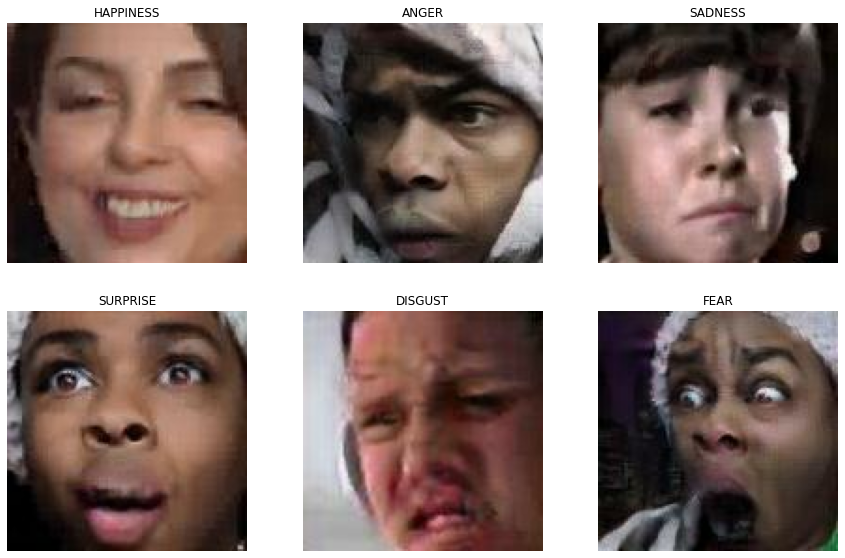

In [ ]:
plt.figure(figsize=(15, 15))
existing = []

for images, labels in training_data.take(1):
    counter = 0
    for i in range(100):
        if expressions[labels[i]] not in existing:
            ax = plt.subplot(3, 3, counter+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(expressions[labels[i]])
            plt.axis("off")
            existing.append(expressions[labels[i]])
            counter+=1

In [ ]:
no_of_expressions = []
for exp in expressions:
    folder_paths = path+exp+'\\*'
    print(f'Images of expression {exp} are {len(glob.glob(folder_paths))}.')
    no_of_expressions.append(len(glob.glob(folder_paths)))

Images of expression ANGER are 8228.
Images of expression DISGUST are 2651.
Images of expression FEAR are 2985.
Images of expression HAPPINESS are 9113.
Images of expression SADNESS are 13040.
Images of expression SURPRISE are 7418.


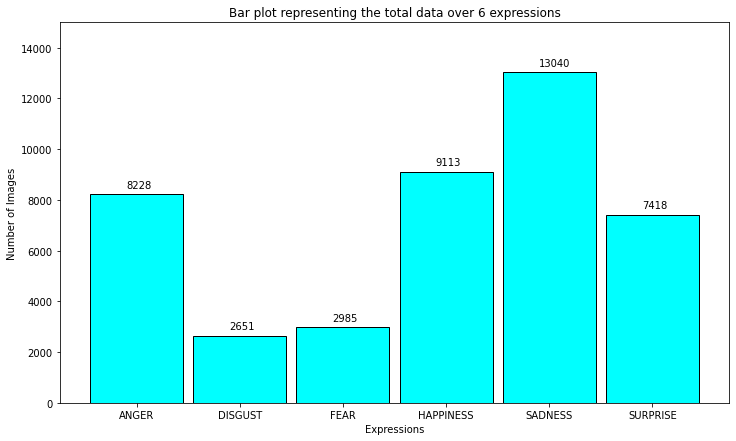

In [ ]:
plt.figure(figsize = (12,7))
plt.bar(expressions, no_of_expressions, width= 0.9, align='center',color='cyan', edgecolor = 'black')
i = 1.0
j = 250

for i in range(len(expressions)):
    plt.annotate(no_of_expressions[i], (-0.1 + i, no_of_expressions[i] + j))

plt.title("Bar plot representing the total data over 6 expressions")
plt.xlabel('Expressions')
plt.ylabel('Number of Images')
plt.ylim([0,15000])
plt.show()

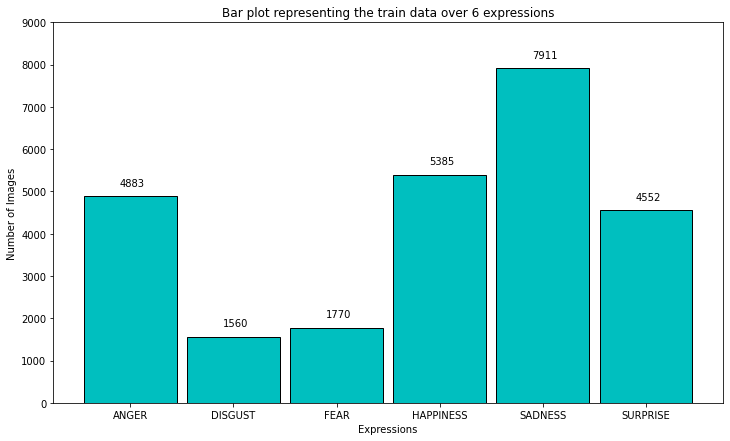

In [ ]:
plt.figure(figsize = (12,7))
plt.bar(expressions, labelcount[0], width= 0.9, align='center', color='c', edgecolor = 'black')
i = 1.0
j = 250

for i in range(len(expressions)):
    plt.annotate(labelcount[0][i], (-0.1 + i, labelcount[0][i] + j))

plt.title("Bar plot representing the train data over 6 expressions")
plt.xlabel('Expressions')
plt.ylabel('Number of Images')
plt.ylim([0,9000])
plt.show()

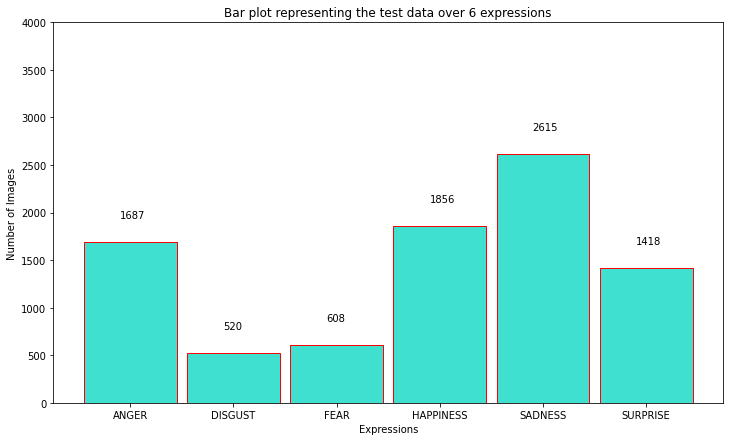

In [ ]:
plt.figure(figsize = (12,7))
plt.bar(expressions, labelcount[1], width= 0.9, align='center',color='turquoise', edgecolor = 'red')
i = 1.0
j = 250

for i in range(len(expressions)):
    plt.annotate(labelcount[1][i], (-0.1 + i, labelcount[1][i] + j))

plt.title("Bar plot representing the test data over 6 expressions")
plt.xlabel('Expressions')
plt.ylabel('Number of Images')
plt.ylim([0,4000])
plt.show()

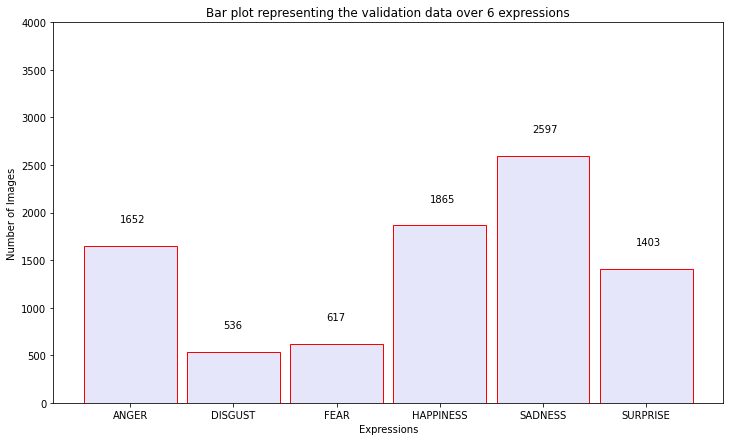

In [ ]:
plt.figure(figsize = (12,7))
plt.bar(expressions, labelcount[2], width= 0.9, align='center',color='lavender', edgecolor = 'red')
i = 1.0
j = 250

for i in range(len(expressions)):
    plt.annotate(labelcount[2][i], (-0.1 + i, labelcount[2][i] + j))

plt.title("Bar plot representing the validation data over 6 expressions")
plt.xlabel('Expressions')
plt.ylabel('Number of Images')
plt.ylim([0,4000])
plt.show()

In [ ]:
normalization = tf.keras.Sequential([
    layers.Resizing(96, 96),
    layers.Rescaling(1./255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1)
])

## MODEL - VGGFace

In [ ]:
model1 = tf.keras.Sequential([
    normalization,
    data_augmentation,
    VGGFace(model='vgg16', include_top=False, input_shape=(96, 96, 3)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(categories, activation='softmax')
])

model1.compile(optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model1.build(input_shape=(None, 128, 128, 3))
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 vggface_vgg16 (Functional)  (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 4096)              18878464  
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 6)                

In [ ]:
history1 = model1.fit(training_data, epochs=20, batch_size=256,
                    validation_data=validation_data)

Epoch 1/20
102/102 [==============================] - 105s 867ms/step - loss: 0.3878 - accuracy: 0.8636 - val_loss: 0.0415 - val_accuracy: 0.9893
Epoch 2/20
102/102 [==============================] - 87s 846ms/step - loss: 0.0761 - accuracy: 0.9761 - val_loss: 0.0277 - val_accuracy: 0.9929
Epoch 3/20
102/102 [==============================] - 81s 779ms/step - loss: 0.0512 - accuracy: 0.9833 - val_loss: 0.0293 - val_accuracy: 0.9897
Epoch 4/20
102/102 [==============================] - 80s 774ms/step - loss: 0.0382 - accuracy: 0.9873 - val_loss: 0.0176 - val_accuracy: 0.9949
Epoch 5/20
102/102 [==============================] - 77s 750ms/step - loss: 0.0312 - accuracy: 0.9901 - val_loss: 0.0212 - val_accuracy: 0.9932
Epoch 6/20
102/102 [==============================] - 77s 749ms/step - loss: 0.0304 - accuracy: 0.9903 - val_loss: 0.0151 - val_accuracy: 0.9958
Epoch 7/20
102/102 [==============================] - 77s 753ms/step - loss: 0.0239 - accuracy: 0.9927 - val_loss: 0.0147 - val_a

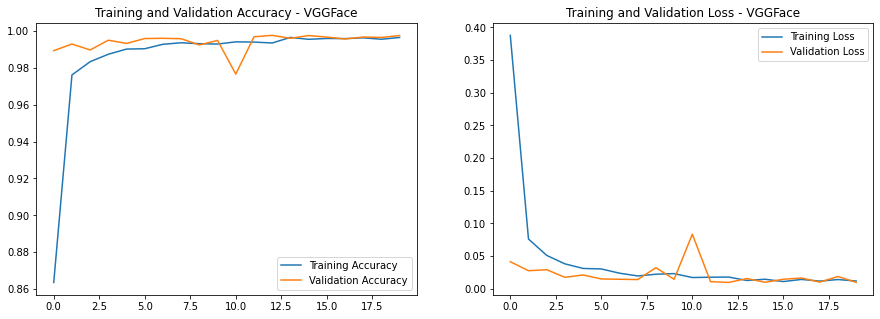

In [ ]:
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']

loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc1, label='Training Accuracy')
plt.plot(epochs_range, val_acc1, label='Validation Accuracy')
# plt.ylim([.9, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - VGGFace')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss1, label='Training Loss')
plt.plot(epochs_range, val_loss1, label='Validation Loss')
# plt.ylim([0, 0.25])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - VGGFace')
plt.show()

In [ ]:
y_hat1 = model1.predict(test_data)

34/34 [==============================] - 9s 177ms/step


In [ ]:
y_pred1 = []
y_true1 = []
for image_batch, label_batch in test_data:
   y_true1.append(label_batch)
   preds = model1.predict(image_batch)
   y_pred1.append(np.argmax(preds, axis = - 1))
    
correct_labels1 = tf.concat([item for item in y_true1], axis = 0)
predicted_labels1 = tf.concat([item for item in y_pred1], axis = 0)

8/8 [==============================] - 0s 25ms/step


## Perfomance over Test Data

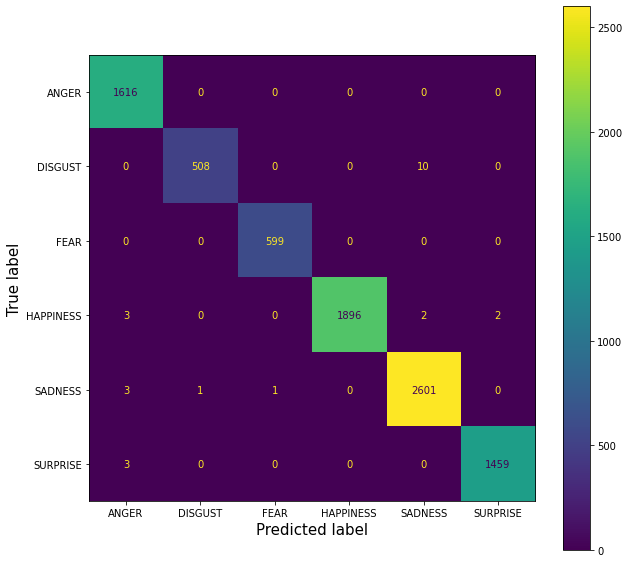

In [ ]:
cm1 = confusion_matrix(correct_labels1, predicted_labels1)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1)
disp = ConfusionMatrixDisplay(cm1, display_labels=expressions)
ax.set_ylabel('True Values',fontsize=15)
ax.set_xlabel('Predicted Values',fontsize=15)
disp.plot(ax=ax)
plt.grid(False)
plt.show()

In [ ]:
print(classification_report(correct_labels1, predicted_labels1, target_names=expressions))

              precision    recall  f1-score   support

       ANGER       0.99      1.00      1.00      1616
     DISGUST       1.00      0.98      0.99       518
        FEAR       1.00      1.00      1.00       599
   HAPPINESS       1.00      1.00      1.00      1903
     SADNESS       1.00      1.00      1.00      2606
    SURPRISE       1.00      1.00      1.00      1462

    accuracy                           1.00      8704
   macro avg       1.00      1.00      1.00      8704
weighted avg       1.00      1.00      1.00      8704



## Production Data

In [ ]:
path1 = 'C:\\Personal Data\\QMUL\\Sem II\\ML Deployment\\Assignment 2\\assignment_2_MLD_qmul\\assignment_2_MLD_qmul\\'
os.listdir(path1)
print(f'Total number of folders : {len(os.listdir(path1))}\n')

Total number of folders : 6



In [ ]:
production_data = tf.keras.utils.image_dataset_from_directory(
    path1,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 26124 files belonging to 6 classes.


In [ ]:
no_of_expressions1 = []
for exp in expressions:
    folder_paths = path1+exp+'\\*'
    print(f'Images of expression {exp} are {len(glob.glob(folder_paths))}.')
    no_of_expressions1.append(len(glob.glob(folder_paths)))

Images of expression ANGER are 3427.
Images of expression DISGUST are 1394.
Images of expression FEAR are 1362.
Images of expression HAPPINESS are 758.
Images of expression SADNESS are 11939.
Images of expression SURPRISE are 7244.


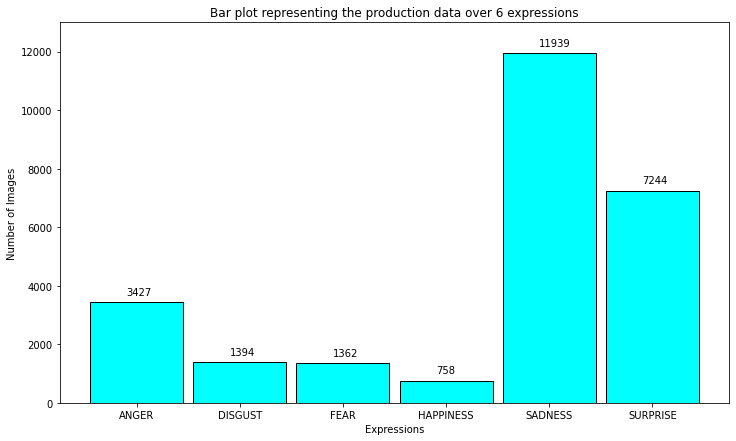

In [ ]:
plt.figure(figsize = (12,7))
plt.bar(expressions, no_of_expressions1, width= 0.9, align='center',color='cyan', edgecolor = 'black')
i = 1.0
j = 250

for i in range(len(expressions)):
    plt.annotate(no_of_expressions1[i], (-0.1 + i, no_of_expressions1[i] + j))

plt.title("Bar plot representing the production data over 6 expressions")
plt.xlabel('Expressions')
plt.ylabel('Number of Images')
plt.ylim([0,13000])
plt.show()

In [ ]:
y_hat_prod = model1.predict(production_data)

103/103 [==============================] - 21s 192ms/step


In [ ]:
y_pred2 = []
y_true2 = []
for image_batch, label_batch in production_data:
   y_true2.append(label_batch)
   preds = model1.predict(image_batch)
   y_pred2.append(np.argmax(preds, axis = - 1))

correct_labels2 = tf.concat([item for item in y_true2], axis = 0)
predicted_labels2 = tf.concat([item for item in y_pred2], axis = 0)

1/1 [==============================] - 0s 110ms/step


## Perfomance over Production Data

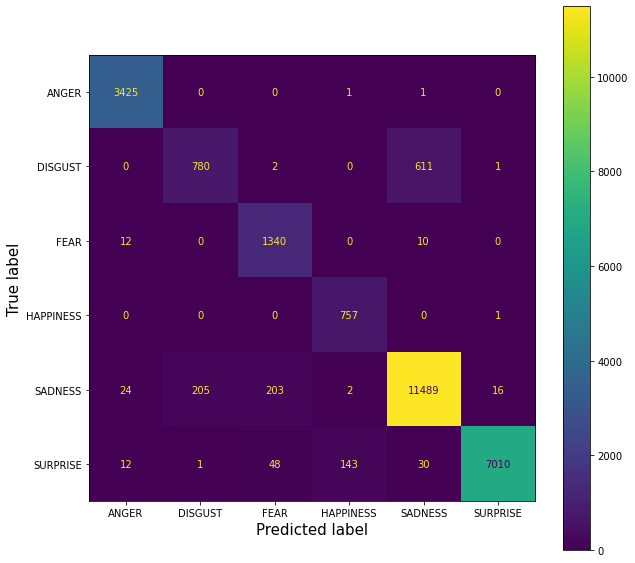

In [ ]:
cm2 = confusion_matrix(correct_labels2, predicted_labels2)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1)
disp = ConfusionMatrixDisplay(cm2, display_labels=expressions)
ax.set_ylabel('True Values',fontsize=15)
ax.set_xlabel('Predicted Values',fontsize=15)
disp.plot(ax=ax)
plt.grid(False)
plt.show()

In [ ]:
print(classification_report(correct_labels2, predicted_labels2, target_names=expressions))

              precision    recall  f1-score   support

       ANGER       0.99      1.00      0.99      3427
     DISGUST       0.79      0.56      0.66      1394
        FEAR       0.84      0.98      0.91      1362
   HAPPINESS       0.84      1.00      0.91       758
     SADNESS       0.95      0.96      0.95     11939
    SURPRISE       1.00      0.97      0.98      7244

    accuracy                           0.95     26124
   macro avg       0.90      0.91      0.90     26124
weighted avg       0.95      0.95      0.95     26124

